In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
import time

import optax

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.variational.vi import VIEngine
from mcjax.proba.neal_funnel import NealFunnel

from mcjax.proba.gauss import GaussianDiag, GaussianFullCov, GaussianDiagMixture, GaussianFullMixture



In [2]:
# initialize PRNG
key = jr.key(0)

In [3]:
# Neal's Funnel example
D = 10
dist = NealFunnel.create(dim=D)
params_NF = dist.init_params(sigma_x=3.)
logdensity = dist.log_prob_only(params=params_NF)
logdensity_batch = jax.vmap(logdensity)

In [4]:
approx_diag = GaussianDiag.create(dim=D)  # returns a Distribution instance
params_diag= approx_diag.init_params()  # initialize parameters
engine_diag = VIEngine.create(approx=approx_diag)

approx_full = GaussianFullCov.create(dim=D)
params_full = approx_full.init_params()  # initialize parameters
engine_full = VIEngine.create(approx=approx_full)

key, key_ = jr.split(key)
num_components_mix = 30
approx_mix = GaussianDiagMixture.create(dim=D, num_components=num_components_mix)
params_mix = approx_mix.init_params(key=key_)  # initialize parameters
engine_diag_mix = VIEngine.create(approx=approx_mix)

key, key_ = jr.split(key)
num_components_mix_full = 30
approx_mix_full = GaussianFullMixture.create(dim=D, num_components=num_components_mix_full)
params_mix_full = approx_mix_full.init_params(key=key_)  # initialize parameters
engine_diag_mix_full = VIEngine.create(approx=approx_mix_full)


approx_name_list = ['diag', 'full', f'mixture_diag_{num_components_mix}', f'mixture_full_{num_components_mix_full}']
approx_list = [approx_diag, approx_full, approx_mix, approx_mix_full]
params_init_list = [params_diag, params_full, params_mix, params_mix_full]
engine_list = [engine_diag, engine_full, engine_diag_mix, engine_diag_mix_full]

In [5]:
optimizer = optax.adam(learning_rate=1e-2)

In [6]:
n_samples = 100
n_iter = 30_000
vi_output_dict = {}

for approx_name, params_init, engine in zip(approx_name_list, params_init_list, engine_list):
    print(f'Running {approx_name} approximation')
    params = params_init


    start_time = time.time()
    results = engine.run(
        params_init=params,
        log_prob=logdensity,
        key=key,
        optimizer=optimizer,
        n_samples=n_samples,
        n_iter=n_iter,
        verbose=False,
    )
    end_time = time.time()
    final_kl = results["kl_trace"][-1]
    print(f'\t Elapsed time: {end_time - start_time:.2f} seconds \t Final KL: {final_kl:.4f}')
    
    vi_output_dict[approx_name] = results
    

Running diag approximation
	 Elapsed time: 6.53 seconds 	 Final KL: 1.8129
Running full approximation
	 Elapsed time: 7.30 seconds 	 Final KL: 1.8147
Running mixture_diag_30 approximation
	 Elapsed time: 86.71 seconds 	 Final KL: 0.0233
Running mixture_full_30 approximation
	 Elapsed time: 272.09 seconds 	 Final KL: 0.0274


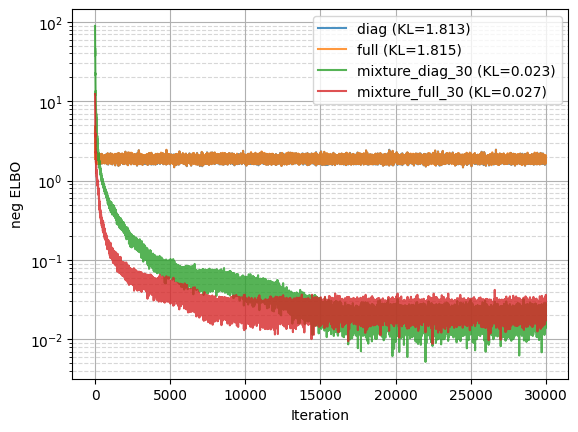

In [7]:
# compute the minimum of all negElbo for plotting
kl_all = jnp.concatenate([vi_output_dict[approx_name]["kl_trace"] for approx_name in approx_name_list], axis=0)
kl_min = jnp.min(kl_all)-0.1

# plot the results
for approx_name in approx_name_list:
    plt.plot(
        vi_output_dict[approx_name]["kl_trace"],
        label=f'{approx_name} (KL={vi_output_dict[approx_name]["kl_trace"][-1]:.3f})',
        alpha=0.8,
    )
plt.yscale('log')

# add label and legend
plt.xlabel('Iteration')
plt.ylabel('neg ELBO')
plt.grid(which="major", linestyle='-')
plt.grid(which="minor", linestyle='--', alpha=0.5)

# add legend upper right
plt.legend(loc='upper right')

In [9]:
# compute a more accurate estimate of the KL with more samples
n_samples_eval = 100_000
for approx_name, approx in zip(approx_name_list, approx_list):
    params = vi_output_dict[approx_name]["params_raw"] 
    samples = approx.sample(params=params, key=key, n_samples=n_samples_eval)
    # evaluate the neg_elbo
    neg_elbo = approx.neg_elbo(
        params=params,
        xs=samples,
        logtarget=logdensity,
        key=key,
        n_samples=n_samples_eval)
    print(f'Final neg ELBO for {approx_name}: {neg_elbo:.4f}')

Final neg ELBO for diag: 1.8748
Final neg ELBO for full: 1.8801
Final neg ELBO for mixture_diag_30: 0.0186
Final neg ELBO for mixture_full_30: 0.0230
